# Emotion Recognition

Udacity Nanodegre Capstone Project

---
### Basic Data Research

First of all, let's look into available data structure and sample some examples.

In [1]:
from IPython.display import display
from basedir import data
import pandas as pd


emotions_data = pd.read_csv(data('fer2013', 'fer2013.csv'))
emotions_data['emotion'] = emotions_data['emotion'].apply(int)
emotions_data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [3]:
def get_subset(labels):
    if isinstance(labels, str):
        labels = [labels]
    return pd.DataFrame(emotions_data[emotions_data.Usage.isin(labels)])


training_data = get_subset(['Training', 'PublicTest'])
del training_data['Usage']

test_data = get_subset('PrivateTest')
del test_data['Usage']

In [10]:
%matplotlib inline
from itertools import chain
import random

import matplotlib.pylab as plt
import numpy as np


verbose_emotion = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


def to_image(data, size=48):
    if isinstance(data, str):
        data = data.split()
    flat = np.array([float(px) for px in data])
    return flat.reshape((size, size))


def sample_emotions(emotions=None):
    grid_spec = {'hspace': 0.5}
    fig, axes = plt.subplots(4, 4, figsize=(8, 8), facecolor='whitesmoke', gridspec_kw=grid_spec)
    df = training_data
    n = len(df)

    if emotions is not None:
        emotions = list(
            i for i, name in enumerate(verbose_emotion)
            if name.lower() in emotions)
        df = df[df.emotion.isin(emotions)]

    # color_map = plt.cm.get_cmap('Greys')
    color_map = plt.cm.get_cmap('coolwarm')

    for ax in chain(*axes):
        record = df.iloc[random.randint(0, n)]
        img = to_image(record.pixels)
        ax.imshow(img, cmap=color_map)
        ax.set_title("Emotion = '%s'" % verbose_emotion[record.emotion],
                     fontdict={'fontsize': 10})
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.savefig("/Users/ck/Desktop/faces.png", format='png')


sample_emotions()

In [24]:
from collections import Counter
from operator import itemgetter

counter = Counter(emotions_data.emotion.tolist())
pairs = sorted(counter.items(), key=itemgetter(0))
verbose = [{"label": i, "verbose": verbose_emotion[i], "count": count}  
           for i, count in pairs]

df = pd.DataFrame(verbose)
print("Emotions set")
display(df)

Emotions set


,count,label,verbose
0,4953,0,Angry
1,547,1,Disgust
2,5121,2,Fear
3,8989,3,Happy
4,6077,4,Sad
5,4002,5,Surprise
6,6198,6,Neutral


---
### More Involved Analysis and Data Transformation

First steps worked with original CSV file and doesn't alternate it in any way. To make original data more suitable for next steps, a few modifications were applied.

Also, as soon as the dataset was excluded from repository (because of its big size), an extra utility was created to download this data. 

In [13]:
import urllib

from IPython.display import display
import pandas as pd
import numpy as np

from basedir import data, DATA_FOLDER


class DataLoader:
    """Incapsulates data downloading process."""
    
    def __init__(downloads_folder='~/data', uncompress=True):
        self.downloads_folder = downloads_folder
        self.uncompress = uncompress
        
    def load(path):
        pass
    
    def _download_url(url):
        pass
    
    def _unarchive(archive_path):
        pass
    

def prepare_data(path):
    pass    


saved_file = 'emotions.dat'
data_path = data(saved_file)

if data_path:
    print('Data already downloaded. Parse into dataframe..')
    emotions = pd.read_pickle(data_path)
    display(emotions.head())
    
else:
    print('Data not found. Trying to download from remote folder..')
    data_link = "https://www.dropbox.com/s/nxzkjku0cfyqv5n/emotions.dat?dl=1"
    try:
        filename, _ = urllib.urlretrieve(data_link)
        emotions = pd.read_pickle(filename)    
        emotions.to_pickle(os.path.join(DATA_FOLDER, saved_file))
    except Exception as e:
        print('ERROR: Data is not available - %s' % str(e))
    else:
        print('Success!')
        display(emotions.head())



Data not found. Trying to download from remote folder..
ERROR: Data is not available - unsupported pickle protocol: 4


In [1]:
import pandas as pd
from basedir import data


def label_matrix(data):
    return data.label.values.reshape(-1, 1)

def pixel_matrix(data):
    return data.drop(['label', 'verbose', 'subset'], axis=1).values


emotions = pd.read_pickle(data('fer2013', 'emotions.dat'))
train_data = emotions[emotions.subset == 'train']
valid_data = emotions[emotions.subset == 'valid']
test_data = emotions[emotions.subset == 'test']

X_train, y_train = pixel_matrix(train_data), label_matrix(train_data)
X_valid, y_valid = pixel_matrix(valid_data), label_matrix(valid_data)

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, 
    learning_curve, StratifiedKFold)
from sklearn.grid_search import GridSearchCV, ParameterGrid


RANDOM_STATE = 1


scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_valid_norm = scaler.fit_transform(X_valid)

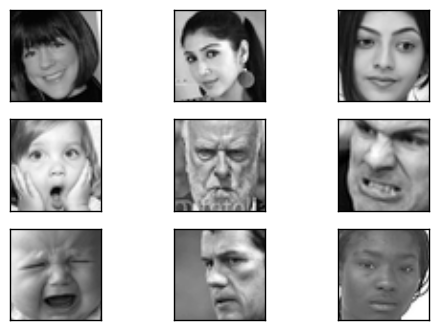

In [61]:
# Verify that images are not malformed during data transformation

from itertools import chain
import random


def sample_images(data, nrow=3, ncol=3):
    rows, columns = data.shape
    fig, axes = plt.subplots(nrow, ncol)    
    indicies = []
    for ax in chain(*axes): 
        index = random.randint(0, rows)
        img = data[index, :].reshape(48, 48)
        ax.imshow(img, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
        indicies.append(index)
    return fig, indicies


fig, indicies = sample_images(X_train_norm)

---
## Baseline Models

To apply baseline models, it was decided to use small data subset at first to speed up development process. The whole dataset training will be performed on dedicated host.

In [88]:
# Selecting a small data subset to perform basic training

def take_subset(X, y, subset_percent=0.1):
    assert X.shape[0] == y.shape[0]
    rows, columns = X.shape
    rows_range = list(range(rows))
    selected_rows = random.sample(rows_range, int(rows*subset_percent))
    return X[selected_rows, :].copy(), y[selected_rows, :].copy()


X_train_subset, y_train_subset = take_subset(X_train_norm, y_train)
print("Subset shapes: X.shape = %s, y.shape = %s" % (X_train_subset.shape, y_train_subset.shape))

Subset shapes: X.shape = (2870, 2304), y.shape = (2870, 1)


### Logistic regression

The first applyied model is Logistic Regression Classifier.

In [ ]:
# Apply baseline models
import numpy as np

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [100.0, 30.0, 10.0, 3.0, 1.0],    
}

logreg = LogisticRegression(random_state=RANDOM_STATE)        
grid_search = GridSearchCV(estimator=logreg, cv=5, param_grid=param_grid, n_jobs=4, verbose=2)
grid_search.fit(X_train_subset, y_train_subset.ravel())

In [79]:
best_logreg = grid_search.best_model_

array([[0],
       [0],
       [2],
       [4],
       [6]])

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 3, 4]
}

random_forest = RandomForestClassifier()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 

# datagen = ImageDataGenerator(featurewise_center=True,
#                              featurewise_std_normalization=True,
#                              zca_whitening=True)
# n, m = sample_grid = (3, 3)
# fig, axes = plt.subplots(n, m, figsize=(10, 10))

# for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=n * m):    
    
#     for ax, pixels, label in zip(chain(*axes), X_batch, y_batch):
#         image = pixels.reshape(28, 28)
#         ax.imshow(cmap=plt.get_cmap('gray'))
#         ax.set_title("Emotion = '%s'" % verbose_emotion[label], fontdict={'fontsize': 10})
#         ax.set_xticks([])
#         ax.set_yticks([])
#         break

